<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/MI/Gr%C3%A1f_neur%C3%A1lis_h%C3%A1l%C3%B3zatok_iMSc_gyakorlat_HALLGAT%C3%93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

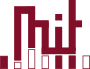 Mesterséges Intelligencia és Rendszertervezés Tanszék, ©2024. BME-MIT, Dr. Gézsi András
# **VIMIAC16 - Mesterséges Intelligencia**
## 2024. Őszi félév
## **iMSc Laborgyakorlat - Gráf neurális hálók**

# 1. Környezet előkészítése

A gyakorlat során a `pytorch` keretrendszert fogjuk használni a neurális hálók tanítására. Először telepítenünk kell a szükséges csomagokat az alábbi kódblokk futtatásával. Ezen kívül definiálunk egy `visualize` nevű függvényt, amelyet a modellek által megtanult reprezentációk ábrázolására fogunk használni.

In [1]:
# Install required packages.
import os
import torch

!pip install torch-geometric

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.1 MB/s eta 0:00:00


# 2. Csomópontok osztályozása gráf neurális hálókkal

A gyakorlat során megismerhetjük, hogy hogyan alkalmazhatunk **gráf neurális hálókat (Graph Neural Network, GNN) csomópont osztályozási feladatokra**.
A feladat során egy gráf kisebb csomópont-részhalmazának valódi címkéit ismerjük, és ezek alapján szeretnénk megjósolni az összes többi csomópont címkéit (*transzduktív, félig-felügyelt tanulás*).

# 2.1. Az adatok előkészítése

Példaként a `Cora` adathalmazt használjuk, amely egy **hivatkozási hálózat**, ahol a csomópontok dokumentumokat reprezentálnak.
Minden csomópontot egy 1433 dimenziós szóelőfordulás (bag-of-words) jellemző vektor ír le.
Két dokumentum akkor van összekötve, ha van köztük hivatkozási kapcsolat.
A feladat az, hogy megjósoljuk minden dokumentum kategóriáját (összesen 7 kategória).

Ezt az adathalmazt először [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) mutatta be a `Planetoid` benchmark részeként.
A gyakorlat során a [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) csomagot fogjuk használni a gráf neruális háló implementálására, valamint az adathalmaz elérésére is a [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid) osztály segítségével:


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


Írassunk ki néhány leíró jellemzőt az adathalmazról, illetve a gráfról az alábbi kódblokk segítségével!

In [3]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number and rate of training nodes: {data.train_mask.sum()} / {int(data.train_mask.sum()) / data.num_nodes * 100.0:.2f}%')
print(f'Number and rate of validation nodes: {data.val_mask.sum()} / {int(data.val_mask.sum()) / data.num_nodes * 100.0:.2f}%')
print(f'Number and rate of test nodes: {data.test_mask.sum()} / {int(data.test_mask.sum()) / data.num_nodes * 100.0:.2f}%')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number and rate of training nodes: 140 / 5.17%
Number and rate of validation nodes: 500 / 18.46%
Number and rate of test nodes: 1000 / 36.93%
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Értelmezzük a kapott jellemzőket!

Láthatjuk, hogy a `Cora` hálózat 2 708 csomópontot és 10 556 élt tartalmaz, ami átlagosan 3,9-es csomópontfokszámot eredményez.
Az adathalmaz tanításához 140 csomópont valódi kategóriáját ismerjük (osztályonként 20-at).
Ez mindössze 5%-os címkézési arányt jelent a tanításhoz.

A gráfnak vannak további attribútumai: `val_mask` és `test_mask`, amelyek megjelölik, hogy mely csomópontokat kell használni validációra és tesztelésre.
Ezen kívül használunk **[adattranszformációkat](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms)** a **`transform=NormalizeFeatures()`** segítségével.
A transzformációk segítségével módosíthatjuk a bemeneti adatokat a neurális hálózatban történő felhasználás előtt, például *normalizálás* vagy *adat augmentáció* céljából.
Itt a szóelőfordulás bemeneti jellemző vektorokat [soronkénti normalizálással](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) alakítjuk át.

Továbbá láthatjuk, hogy ez a hálózat irányítatlan, és nincsenek izolált csomópontok (minden dokumentumnak van legalább egy hivatkozása).


## 2.2 Többrétegű Perceptron Hálózat (MLP) tanítása

Elméletileg képesnek kell lennünk megjósolni egy dokumentum kategóriáját kizárólag annak tartalma alapján, vagyis a szóelőfordulás jellemző reprezentációja alapján, anélkül, hogy figyelembe vennénk a relációs információkat.

Ezt ellenőrizzük úgy, hogy építünk egy egyszerű MLP-t, amely kizárólag a bemeneti csomópont jellemzőkkel dolgozik (az összes csomópontra közös súlyokat használva):


In [4]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Vizualizáljuk a **nem betanított** MLP hálózatunk csomópont-beágyazásait. A vizualizációhoz TSNE-t használunk, hogy a 7-dimenziós csomópont-beágyazásokat egy 2D síkra vetítsük. Mit tapasztalunk?


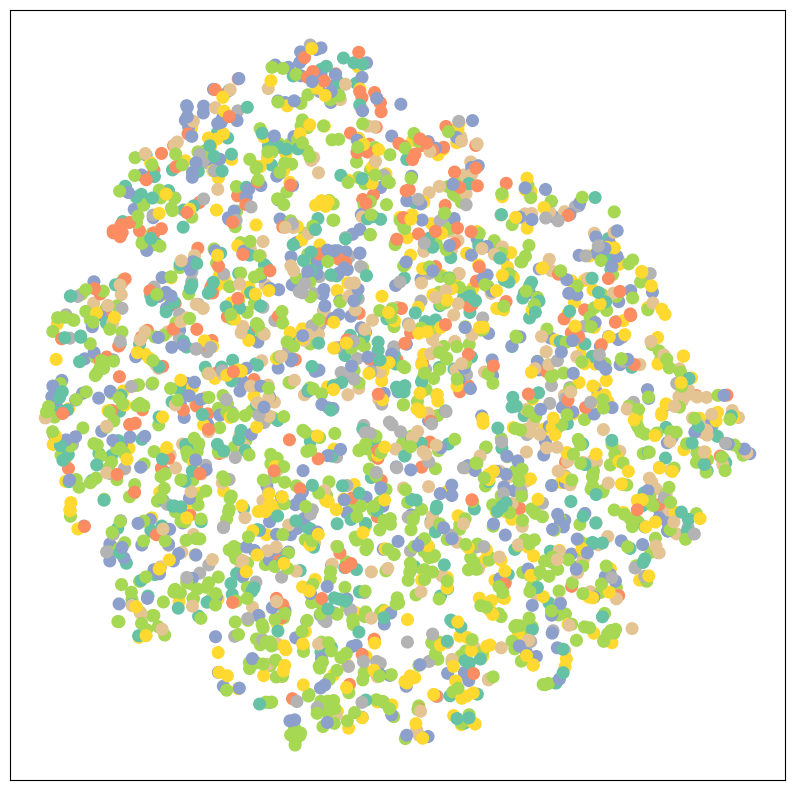

In [5]:
model.eval()

out = model(data.x)
visualize(out, color=data.y)

MLP hálózatunk két lineáris rétegből áll, amelyeket [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) nemlinearitás és [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout) egészít ki.
Először az 1433-dimenziós jellemzővektort egy alacsony dimenziós beágyazásra csökkentjük (`hidden_channels=16`), míg a második lineáris réteg egy osztályozóként működik, amelynek célja, hogy minden alacsony dimenziós csomópont-beágyazást a 7 osztály egyikébe képezzen le.

Végezzük el az egyszerű MLP modellünk tanítását! A tanítás során a **keresztentrópia veszteséget** és az **Adam optimalizálót** használjuk.
Ezen kívül definiálunk egy **`test` függvényt**, amely kiértékeli, hogy a végső modellünk mennyire teljesít jól a teszt csomópontokon (amelyek címkéit nem láttuk a tanítás során).


In [6]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
      train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.
      valid_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
      valid_acc = int(valid_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return train_acc, valid_acc, test_acc


for epoch in range(1, 201):
    loss = train()
    train_acc, valid_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train acc: {train_acc:.4f}, Validation acc: {valid_acc:.4f}, Test acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9618, Train acc: 0.1429, Validation acc: 0.1140, Test acc: 0.1030
Epoch: 002, Loss: 1.9590, Train acc: 0.1429, Validation acc: 0.1140, Test acc: 0.1030
Epoch: 003, Loss: 1.9579, Train acc: 0.1429, Validation acc: 0.1140, Test acc: 0.1030
Epoch: 004, Loss: 1.9554, Train acc: 0.1429, Validation acc: 0.1140, Test acc: 0.1030
Epoch: 005, Loss: 1.9536, Train acc: 0.1714, Validation acc: 0.1120, Test acc: 0.1030
Epoch: 006, Loss: 1.9487, Train acc: 0.2357, Validation acc: 0.1160, Test acc: 0.1150
Epoch: 007, Loss: 1.9466, Train acc: 0.2857, Validation acc: 0.1320, Test acc: 0.1350
Epoch: 008, Loss: 1.9417, Train acc: 0.2857, Validation acc: 0.1400, Test acc: 0.1530
Epoch: 009, Loss: 1.9417, Train acc: 0.2857, Validation acc: 0.1400, Test acc: 0.1410
Epoch: 010, Loss: 1.9394, Train acc: 0.2857, Validation acc: 0.1220, Test acc: 0.1280
Epoch: 011, Loss: 1.9383, Train acc: 0.2857, Validation acc: 0.1140, Test acc: 0.1210
Epoch: 012, Loss: 1.9316, Train acc: 0.2786, Validatio

A modell betanítása után meghívhatjuk a `test` függvényt, hogy lássuk, mennyire jól teljesít a modell az ismeretlen címkéken.
Ebben az esetben a modell pontossága érdekel minket, azaz a helyesen osztályozott csomópontok aránya (a `test` függvény harmadik kimenete):

In [7]:
train_acc, valid_acc, test_acc = test()
print(f'Train acc: {train_acc:.4f}, Validation acc: {valid_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 1.0000, Validation acc: 0.6080, Test acc: 0.5840


Vizualizáljuk a **betanított** MLP hálózatunk csomópont-beágyazásait. Mit tapasztalunk a betanítatlan modellhez képest?

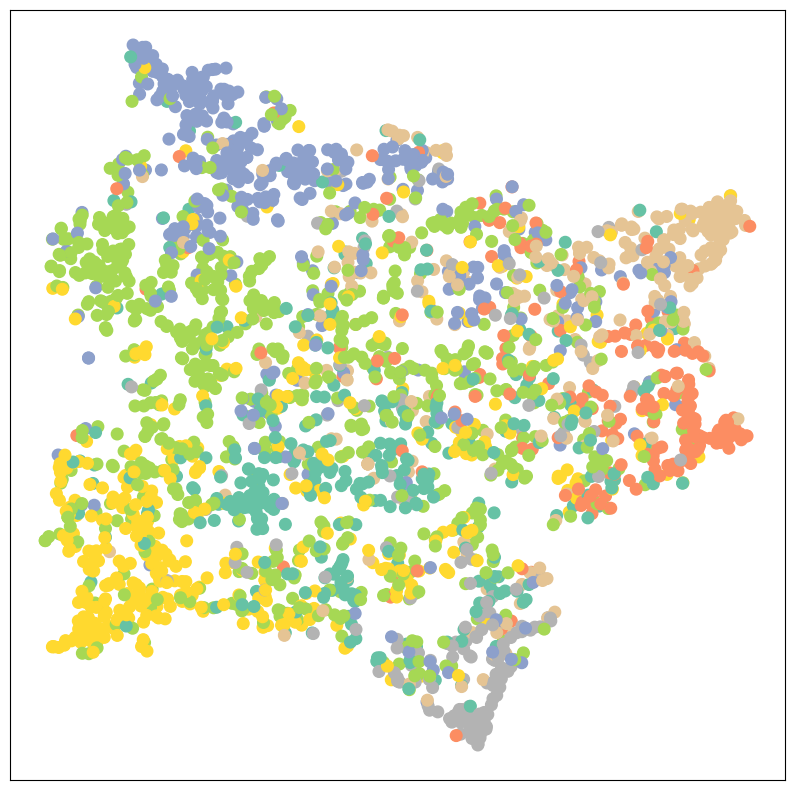

In [8]:
model.eval()

out = model(data.x)
visualize(out, color=data.y)

Ahogy látható, az MLP modellünk meglehetősen rosszul teljesít, mindössze kb. 58,4%-os teszt pontossággal.
De miért nem teljesít jobban az MLP?
Ennek fő oka, hogy a modell erősen túlilleszkedik, mivel csak **kevés tanító csomóponthoz** fér hozzá, és ezért rosszul általánosít az ismeretlen csomópont-reprezentációkra.

Ezenkívül hiányzik a modellből egy fontos torzítás: **Az idézett cikkek nagyon valószínű, hogy kapcsolódnak a dokumentum kategóriájához**.
Itt lépnek be a képbe a gráf neurális hálók, amelyek segíthetnek javítani modellünk teljesítményén.


## 2.3. Gráf Neurális Háló (GNN) tanítása

### Gráf konvolúciós hálózat (Graph Convolution Network, GCN)

Egyszerűen átalakíthatjuk MLP modellünket GNN-né, ha a `torch.nn.Linear` rétegeket lecseréljük a PyG GNN operátoraira.

A lineáris rétegeket a [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) modulra cseréljük.
A **GCN réteg** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) definíciója a következő:

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

ahol $\mathbf{W}^{(\ell + 1)}$ egy tanítható súlymátrix, amelynek mérete `[num_output_features, num_input_features]`, és $c_{w,v}$ egy rögzített normalizációs együttható minden élhez. Az összegzés során a $v$ csomópont minden szomszédja reprezentációjának (illetve a $v$ csomópont saját reprezentációjának) $c_{w,v}$-vel súlyozott összegét kiszámítjuk, majd a súlymátrixszal transzformáljuk.


Ezzel szemben egy egyszerű `Linear` réteg definíciója:

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

ami nem veszi figyelembe a szomszédos csomópontok információit.


In [9]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Vizualizáljuk a **nem betanított** GNN hálózatunk csomópont-beágyazásait. Mit tapasztalunk a betanítatlan MLP modellhez képest?

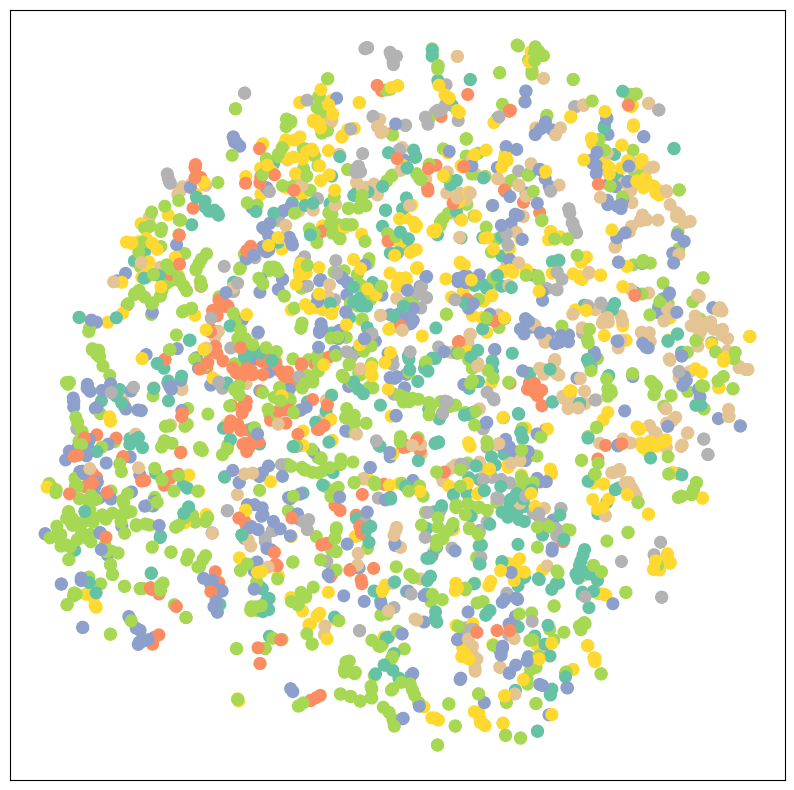

In [10]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

Biztosan jobb eredményt érhetünk el a modellünk betanításával.
A tanítási és tesztelési folyamat ismét ugyanaz, de ezúttal a GNN modellünk bemeneteként a csomópont jellemzőket (`x`) **és** a gráf kapcsolati információit (`edge_index`) is használjuk. Figyeljük meg a kódszintű különbséget az MLP és a GNN modell tanítása között!

In [11]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
      train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.
      valid_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
      valid_acc = int(valid_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return train_acc, valid_acc, test_acc


for epoch in range(1, 201):
    loss = train()
    train_acc, valid_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train acc: {train_acc:.4f}, Validation acc: {valid_acc:.4f}, Test acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Epoch: 001, Loss: 1.9462, Train acc: 0.3500, Validation acc: 0.2640, Test acc: 0.2470
Epoch: 002, Loss: 1.9390, Train acc: 0.3714, Validation acc: 0.2880, Test acc: 0.3310
Epoch: 003, Loss: 1.9287, Train acc: 0.5643, Validation acc: 0.3100, Test acc: 0.3400
Epoch: 004, Loss: 1.9186, Train acc: 0.6500, Validation acc: 0.4020, Test acc: 0.4390
Epoch: 005, Loss: 1.9032, Train acc: 0.6857, Validation acc: 0.4340, Test acc: 0.4810
Epoch: 006, Loss: 1.8933, Train acc: 0.7571, Validation acc: 0.4980, Test acc: 0.5280
Epoch: 007, Loss: 1.8814, Train acc: 0.8143, Validation acc: 0.5580, Test acc: 0.5950
Epoch: 008, Loss: 1.8682, Train acc: 0.8429, Validation acc: 0.6040, Test acc: 0.6470
Epoch: 009, Loss: 1.8546, Train acc: 0.8571, Validation acc: 0.6280, Test acc: 0.6600
Epoch: 010, Loss: 1.8403, Train acc: 0.8500, Validation acc: 0.6420, Test acc: 0.6630
Epoch: 011, Loss: 1.8271, Train acc: 0.8500, Validation acc: 0.6340, Test acc:

A modell betanítása után ellenőrizhetjük annak pontosságát a teszt csomópontokon:

In [12]:
train_acc, valid_acc, test_acc = test()
print(f'Train acc: {train_acc:.4f}, Validation acc: {valid_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 0.9929, Validation acc: 0.8040, Test acc: 0.8310


**Meg is van!**

A lineáris rétegek GNN rétegekre való lecserélésével **83,1%-os teszt pontosságot** értünk el!
Ez éles ellentétben áll az MLP által elért 59%-os teszt pontossággal, ami azt jelzi, hogy a relációs információk kulcsszerepet játszanak a jobb teljesítmény elérésében.

Ezt ismét ellenőrizhetjük, ha megnézzük a **betanított** modell kimeneti beágyazásait, amelyek most sokkal jobb klaszterezést eredményeznek az azonos kategóriájú csomópontok esetében.


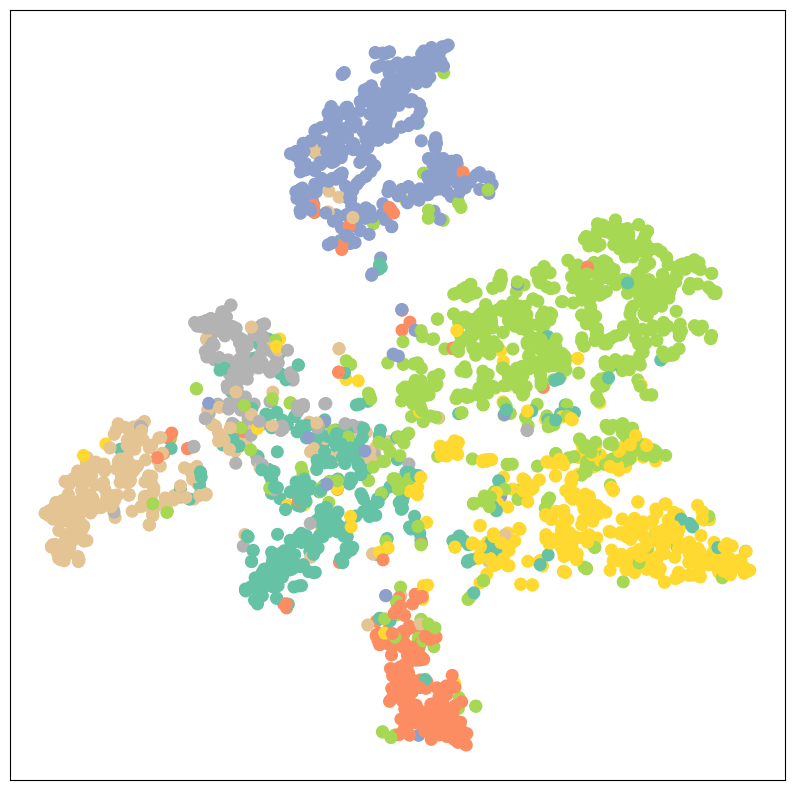

In [13]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

&#x1F4DD; Hogyan viselkedik a GNN, ha változtatjuk (csökkentjük vagy növeljük) a rejtett réteg dimenzióját vagy a rétegek számát? Segít-e egyáltalán a rétegek számának növelése? Az alábbi kódblokk módosításával vizsgáljuk meg, hogy mekkora a validációs pontosság a következő esetekben:
* GCN rétegek száma: 1, rejtett réteg dimenziója: 16
* GCN rétegek száma: 2, rejtett réteg dimenziója: 16
* GCN rétegek száma: 3, rejtett réteg dimenziója: 16
* GCN rétegek száma: 2, rejtett réteg dimenziója: 8
* GCN rétegek száma: 2, rejtett réteg dimenziója: 64

Mit tapasztal?

In [14]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()

print(model)

for epoch in range(1, 201):
    loss = train()                            # from previous definition
    if epoch % 20 == 0:
      train_acc, valid_acc, test_acc = test() # from previous definition
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train acc: {train_acc:.4f}, Validation acc: {valid_acc:.4f}, Test acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

GCN(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 7)
)
Epoch: 020, Loss: 1.2063, Train acc: 0.9429, Validation acc: 0.7840, Test acc: 0.8060
Epoch: 040, Loss: 0.6127, Train acc: 0.9857, Validation acc: 0.7920, Test acc: 0.8060
Epoch: 060, Loss: 0.4093, Train acc: 0.9857, Validation acc: 0.7940, Test acc: 0.8100
Epoch: 080, Loss: 0.3730, Train acc: 0.9857, Validation acc: 0.7920, Test acc: 0.8110
Epoch: 100, Loss: 0.3722, Train acc: 0.9929, Validation acc: 0.8040, Test acc: 0.8190
Epoch: 120, Loss: 0.3558, Train acc: 1.0000, Validation acc: 0.8120, Test acc: 0.8090
Epoch: 140, Loss: 0.3582, Train acc: 0.9929, Validation acc: 0.7800, Test acc: 0.8080
Epoch: 160, Loss: 0.3768, Train acc: 1.0000, Validation acc: 0.8080, Test acc: 0.8170
Epoch: 180, Loss: 0.3485, Train acc: 1.0000, Validation acc: 0.8000, Test acc: 0.8130
Epoch: 200, Loss: 0.3252, Train acc: 0.9929, Validation acc: 0.7780, Test acc: 0.8170


### Gráf figyelmi hálózat (Graph Attention Network, GAT)
Próbálkozzunk meg különböző GNN rétegek használatával, hogy lássuk, hogyan változik a modell teljesítménye! Mi történik, ha az összes GCNConv réteget [`GATConv`](https://pytorch-geometric.readthedocs.io/en/2.5.3/generated/torch_geometric.nn.conv.GATConv.html) rétegekre cseréljük, amelyek figyelmi mechanizmust (attention) használnak?

&#x1F4DD; Alkossunk egy 2-rétegű GAT modellt, amely 8 figyelmi fejjel (attention head) rendelkezik az első rétegben és 1 figyelmi fejjel a második rétegben! Alkalmazzunk 0,6-os dropout arányt a bemeneti rétegen és az első GATConv réteg után. Az első GATConv rétegben 8 dimenziót használjunk figyelmi fejenként és ezek kimenetét konkatenáljuk össze. Hogyan változik a futási idő? Mekkora a modell pontossága a teszt adatokon?

In [15]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        # TODO
        # self.conv1 = ...
        # self.conv2 = ...

    def forward(self, x, edge_index):
        # TODO
        # x = ...
        return x

# TODO
# model = ...

print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-3)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train()                            # from previous definition
    if epoch % 20 == 0:
      train_acc, valid_acc, test_acc = test() # from previous definition
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train acc: {train_acc:.4f}, Validation acc: {valid_acc:.4f}, Test acc: {test_acc:.4f}')

GCN(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 7)
)
Epoch: 020, Loss: 0.3536, Train acc: 1.0000, Validation acc: 0.8020, Test acc: 0.8180
Epoch: 040, Loss: 0.3339, Train acc: 1.0000, Validation acc: 0.7940, Test acc: 0.8180
Epoch: 060, Loss: 0.3702, Train acc: 1.0000, Validation acc: 0.8000, Test acc: 0.8200
Epoch: 080, Loss: 0.3252, Train acc: 1.0000, Validation acc: 0.7900, Test acc: 0.8130
Epoch: 100, Loss: 0.3398, Train acc: 1.0000, Validation acc: 0.7960, Test acc: 0.8080
Epoch: 120, Loss: 0.3471, Train acc: 0.9929, Validation acc: 0.7900, Test acc: 0.8180
Epoch: 140, Loss: 0.3288, Train acc: 1.0000, Validation acc: 0.7980, Test acc: 0.8150
Epoch: 160, Loss: 0.3315, Train acc: 1.0000, Validation acc: 0.7980, Test acc: 0.8230
Epoch: 180, Loss: 0.3366, Train acc: 1.0000, Validation acc: 0.8040, Test acc: 0.8130
Epoch: 200, Loss: 0.3184, Train acc: 0.9929, Validation acc: 0.7920, Test acc: 0.8210


# **3. Feladatbeadás**

# 3.1 Feladat

Ebben a házi feladatban a cél a **WikiCS** gráf csomópontjainak osztályozása lesz gráf neurális hálózat segítségével. Az eredeti adathalmaz [innen](https://arxiv.org/pdf/2007.02901) származik.

A **WikiCS** adatbázis egy **hivatkozási hálózat**, amelyet gráf-alapú tanulási feladatokhoz használnak. A következőket tartalmazza:

- A **csomópontok** Wikipédia-cikkeket jelentenek, amelyek számítástechnikai témákkal kapcsolatosak.
- Az **élek** a cikkek közötti hivatkozásokat (linkeket) reprezentálják.
- A **csomópont jellemzők** a cikkek szövegének TF-IDF reprezentációjából származnak.
- A **csomópont címkék** a számítástechnika 10 különböző részterületét jelölik (pl. mesterséges intelligencia, algoritmusok, számítógépes látás).

A WikiCS adathalmazt félig felügyelt csomópont-osztályozási feladatokra tervezték, és gyakran használják gráf neurális hálók kiértékelésére. Az adathalmaz valósághűbb, mint az egyszerűbb benchmarkok (pl. Cora vagy Citeseer), mivel tartalmaz zajt és osztály-egyensúlytalanságot, amelyek gyakoriak a valós hálózatokban.

Az adathalmaz főbb jellemzői:
- **11 701 csomópont**
- **216 123 él**
- **300-dimenziós jellemző vektorok csomópontonként**

Az adathalmaz betöltésére használjuk az alábbi kódblokkot:
```python
import json
import warnings
from itertools import chain
from typing import Callable, List, Optional

import torch

from torch_geometric.data import Data, InMemoryDataset, download_url
from torch_geometric.utils import to_undirected


class WikiCSLab(InMemoryDataset):
    url = 'https://github.com/pmernyei/wiki-cs-dataset/raw/master/dataset'

    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None
    ) -> None:
        super().__init__(root, transform, None, force_reload=True)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self) -> List[str]:
        return ['data.json']

    @property
    def processed_file_names(self) -> str:
        return 'data_undirected.pt'

    def download(self) -> None:
        for name in self.raw_file_names:
            download_url(f'{self.url}/{name}', self.raw_dir)

    def process(self) -> None:
        with open(self.raw_paths[0]) as f:
            data = json.load(f)

        x = torch.tensor(data['features'], dtype=torch.float)
        y = torch.tensor(data['labels'], dtype=torch.long)

        edges = [[(i, j) for j in js] for i, js in enumerate(data['links'])]
        edges = list(chain(*edges))  # type: ignore
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_index = to_undirected(edge_index, num_nodes=x.size(0))

        train_mask = torch.tensor(data['train_masks'], dtype=torch.bool)
        train_mask = train_mask.t().contiguous()[:,0]

        val_mask = torch.tensor(data['val_masks'], dtype=torch.bool)
        val_mask = val_mask.t().contiguous()[:,0]

        data = Data(x=x, y=y, edge_index=edge_index, train_mask=train_mask, val_mask=val_mask)

        self.save([data], self.processed_paths[0])

dataset = WikiCSLab(root='data/WikiCS')
```

## 3.2 Beadandó

A moodle felületre két fájlt kell feltölteni:
* Egy **`model.py`** nevű fájlt, amely a modell definícióját tartalmazza. Nem szükséges nulláról futtatható módon tartalmaznia a teljes megoldást, de az értékelő számára ki kell derüljön belőle a felhasznált modell felépítése és a tanítás folyamata. (Ezt a fájlt nem értékeljük automatikusan, de a reprodukálhatóság érdekében ezt is fel kell tölteni.)
* Egy **`y.csv`** nevű fájlt **az összes csomópont prediktált osztályával**, tehát a fájlnak 11 701 sort kell tartalmaznia, soronként egy-egy integer értékkel. Python környezetben a numpy segítségével a `np.savetxt` függvénnyel exportálhatjuk az `y_pred` változó értékét az `y.csv` fájlba.

```python
np.savetxt('y.csv', y_pred, fmt="%g")
```

Tehát soronként egyetlen kimenetet kell tartalmaznia az eredmény .csv fájlnak, például:

```python
0
1
1
0
3
2
2
3
0
```

## 3.3 Kiértékelés

A kiértékelés során csak bizonyos teszt csomópontokon mért pontosságot fogunk értékelni. Ha ez meghaladja a 75%-ot, akkor tekintjük elfogadottnak a megoldást. Tipp: a teszt csomópontokon mért várható pontosság jól becsülhető a validációs csomópontokon mért pontossággal, feltéve ha nem végzünk túlságosan kimerítő hiperparaméter-optimalizációt (melynek során rátanulunk a validációs adatokra).

## 3.3 Megoldási környezet

A javasolt megoldási környezet a Google Colaboratory, ahol iPython notebookokat lehet futtatni. Javasoljuk, hogy erről a notebookról először a saját Google Drive-ba készítsen egy másolatot, majd alakítsa át úgy, hogy a fent említett adathalmazt használja.

**Link a beadáshoz:** https://edu.vik.bme.hu/mod/quiz/view.php?id=152741



> ## Köszönetnyilvánítás
> Ez a gyakorlat a Stanford Egyetem [CS224W: Machine Learning with Graphs](https://web.stanford.edu/class/cs224w/) kurzusának anyagai alapján készült.